In [1]:
import torch
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import numpy as np
import os
import torch.optim as optim

torch.manual_seed(777)  # reproducibility

In [2]:
from __future__ import division

In [3]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import time
from torchsummary import summary
from torch.optim import lr_scheduler
#from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [4]:
#%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary
from torch.optim import lr_scheduler
#from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
import torchvision.models as models

from PIL import Image


from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import random
import time
import os
import cv2
from skimage.io import imread

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
torch.cuda.device_count()

1L

In [7]:
torch.cuda.get_device_capability(device=None)

(7, 5)

In [8]:
# hyper-parameters
bs = 32
keep_prob = 0.7 # 0.7

In [9]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(1.0, 0.8)),
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=250),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        #transforms.Grayscale(num_output_channels=3),
        transforms.CenterCrop(size=250),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])   
}

/home/ali/project/local/lib/python2.7/site-packages/torchvision/transforms/transforms.py:619: UserWarning: range should be of kind (min, max)
  warnings.warn("range should be of kind (min, max)")


In [10]:
dataset = 'Datasets/casia-data'

train_directory = os.path.join(dataset, 'train')
#valid_directory = os.path.join(dataset, 'valid')
test_directory = os.path.join(dataset, 'test')

#num_classes = 2
#print(num_classes)

#trainTransform  = tv.transforms.Compose([tv.transforms.Grayscale(num_output_channels=1)

#casia_train = {'train': datasets.ImageFolder(root=train_directory, transform=[transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])}
#casia_test = {'test': datasets.ImageFolder(root=test_directory, transform=[transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])}


casia_train = {'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train'])}
casia_test = {'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['valid'])}
#data = {
#    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
#    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
#}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in casia_train['train'].class_to_idx.items()}
print(idx_to_class)

# dataset loader
#data_loader = torch.utils.data.DataLoader(dataset=casia_train,
                                         # batch_size=batch_size,
                                         # shuffle=True)
        
        
train_data_loader = DataLoader(casia_train['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(casia_test['test'], batch_size=bs, shuffle=True)



items = iter(train_data_loader)
image, label = items.next()

{0: 'Female', 1: 'Male'}


In [11]:
train_data_size = len(casia_train['train'])
print (train_data_size)
#valid_data_size = len(data['valid'])
valid_data_size = len(casia_test['test'])
#print test_data_size
print (valid_data_size)

23116
7771


In [12]:
# Display informations about the dataset
print('The training dataset:\t',casia_train)
print('\nThe testing dataset:\t',casia_test)

('The training dataset:\t', {'train': Dataset ImageFolder
    Number of datapoints: 23116
    Root location: Datasets/casia-data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(1.0, 0.8), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               Grayscale(num_output_channels=3)
               RandomRotation(degrees=(-15, 15), resample=False, expand=False)
               RandomHorizontalFlip(p=0.5)
               CenterCrop(size=(250, 250))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )})
('\nThe testing dataset:\t', {'test': Dataset ImageFolder
    Number of datapoints: 7771
    Root location: Datasets/casia-data/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(250, 250))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], st

In [13]:
def show_transformed_image(image):
    np_image = image.numpy()
    plt.figure(figsize=(40,40))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

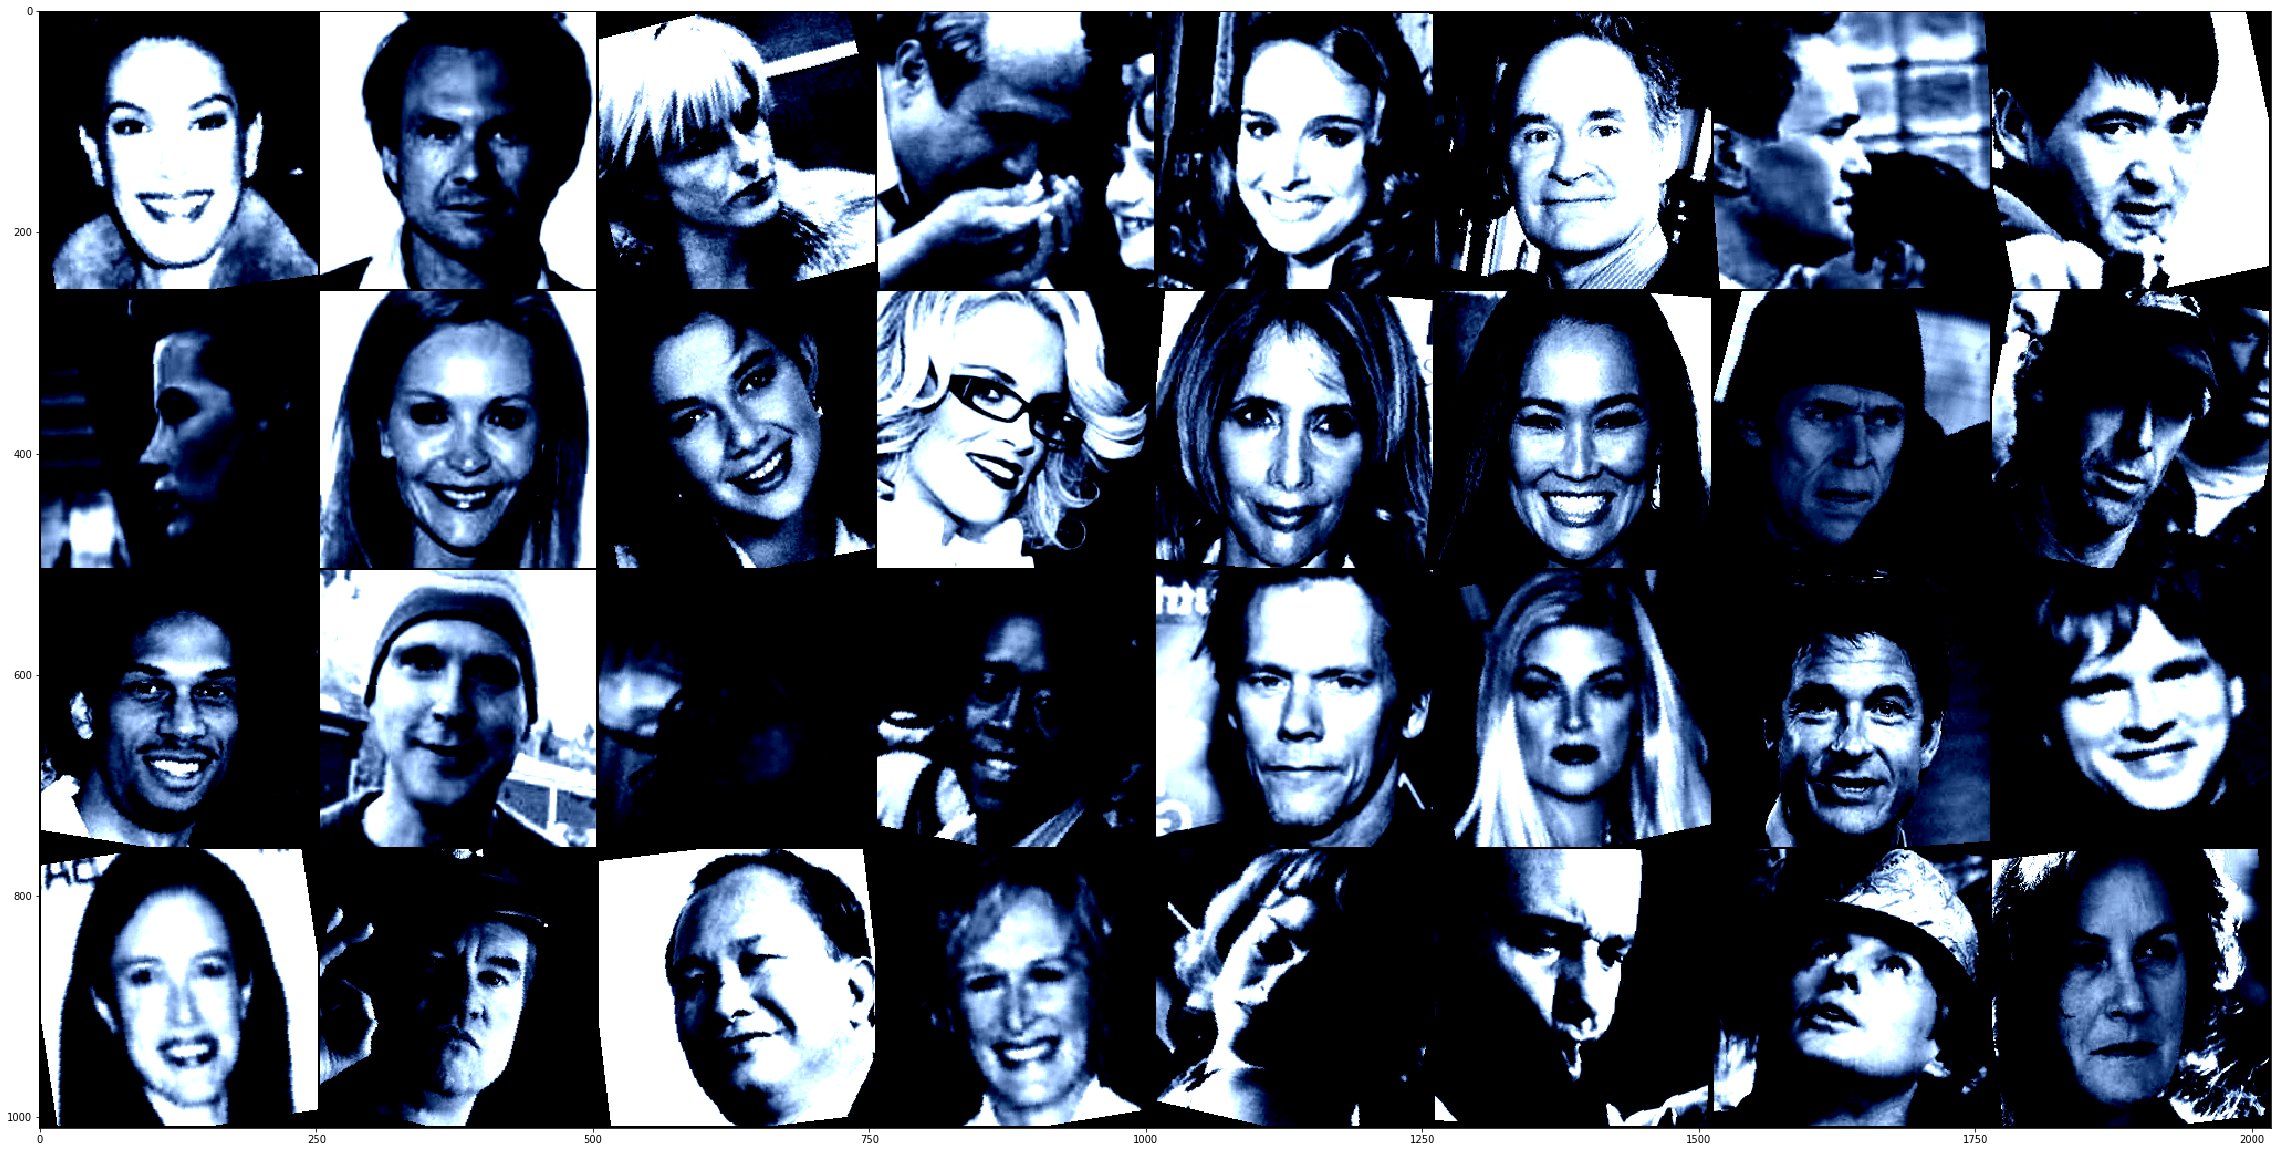

In [14]:
from torchvision.utils import make_grid
show_transformed_image(make_grid(image))

In [16]:
# Implementation of CNN/ConvNet Model using PyTorch (depicted in the picture above)

# Proposed CNN architecture for initial training

class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(p=1 - keep_prob))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 8192, 256, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L4 FC 4x4x128 inputs -> 625 outputs
        #self.fc2 = torch.nn.Linear(1024, 512, bias=True)
        #torch.nn.init.xavier_uniform(self.fc2.weight)
        #self.layer5 = torch.nn.Sequential(
        #    self.fc2,
        #    torch.nn.ReLU(),
        #    torch.nn.Dropout(p=1 - keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(256, 2, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        #out = self.fc3(out)
        return out


# instantiate CNN model
model = CNN()
model.cuda()
#model

/home/ali/project/lib/python2.7/site-packages/ipykernel_launcher.py:36: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (fc1): Linear(in_features=131072, out_features=256, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=131072, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (fc2): Linear(in_features=256, out_features=2, bias=Tr

In [17]:
for param in model.parameters():
    print(param.size())

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([256, 131072])
torch.Size([256])
torch.Size([2, 256])
torch.Size([2])


In [18]:
from torch.optim import Adam

cnn_model = model.cuda()
#loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adamax(cnn_model.parameters(), lr=0.005)
#optimizer = torch.optim.Adamax(cnn_model.parameters(), lr=0.005)
optimizer = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.95, weight_decay=1e-5)
#loss_fn = nn.BCELoss()
#optimizer = Adam(cnn_model.parameters(), lr=0.005)
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()


net = cnn_model
print(net)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (fc1): Linear(in_features=131072, out_features=256, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=131072, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (fc2): Linear(in_features=256, out_features=2, bias=Tr

In [18]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
layer1.0.weight 	 torch.Size([32, 3, 3, 3])
layer1.0.bias 	 torch.Size([32])
layer2.0.weight 	 torch.Size([64, 32, 3, 3])
layer2.0.bias 	 torch.Size([64])
layer3.0.weight 	 torch.Size([128, 64, 3, 3])
layer3.0.bias 	 torch.Size([128])
fc1.weight 	 torch.Size([256, 131072])
fc1.bias 	 torch.Size([256])
layer4.0.weight 	 torch.Size([256, 131072])
layer4.0.bias 	 torch.Size([256])
fc2.weight 	 torch.Size([2, 256])
fc2.bias 	 torch.Size([2])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.95, 'dampening': 0, 'weight_decay': 1e-05, 'nesterov': False, 'params': [140640091421000, 140640514423400, 140640091483448, 140640091481720, 140640091483592, 140640091483664, 140640091483736, 140640091483808, 140640091483880, 140640091483952]}]


In [19]:
def train_and_validate(model, loss_criterion, optimizer, epochs=10):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            #outputs = model(inputs)
            outputs = cnn_model(inputs)
            
            # Compute loss
            #loss = loss_criterion(outputs, labels)
            loss = loss_fn(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)
                #print outputs.size()
                #print inputs.size()
                #print labels

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [165]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Print the model to be trained
summary(net, input_size=(3, 250, 250), batch_size=bs, device="cuda")
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs)

# Train the model for 40 epochs
num_epochs = 50
trained_model, history = train_and_validate(cnn_model, loss_fn, optimizer, num_epochs)
torch.save(history, dataset+'_history.pt')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 250, 250]             896
              ReLU-2         [32, 32, 250, 250]               0
         MaxPool2d-3         [32, 32, 125, 125]               0
           Dropout-4         [32, 32, 125, 125]               0
            Conv2d-5         [32, 64, 125, 125]          18,496
              ReLU-6         [32, 64, 125, 125]               0
         MaxPool2d-7           [32, 64, 62, 62]               0
           Dropout-8           [32, 64, 62, 62]               0
            Conv2d-9          [32, 128, 62, 62]          73,856
             ReLU-10          [32, 128, 62, 62]               0
        MaxPool2d-11          [32, 128, 32, 32]               0
          Dropout-12          [32, 128, 32, 32]               0
           Linear-13                  [32, 256]      33,554,688
           Linear-14                  [

Epoch: 50/50
Epoch : 049, Training: Loss: 0.1127, Accuracy: 95.7605%, 
		Validation : Loss : 0.2313, Accuracy: 90.1042%, Time: 109.3843s


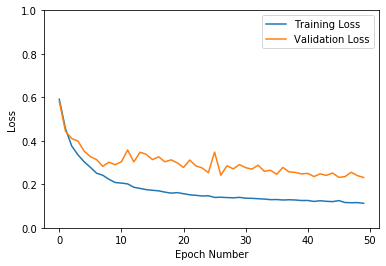

In [166]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

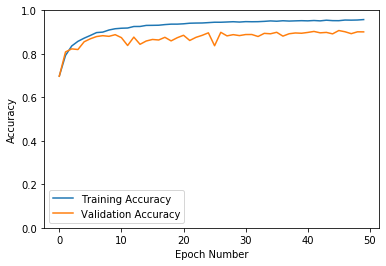

In [167]:
plt.plot(history[:,2:4])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [20]:
print("The state dict keys: \n\n", net.state_dict().keys())

The state dict keys: 

 odict_keys(['layer1.0.weight', 'layer1.0.bias', 'layer2.0.weight', 'layer2.0.bias', 'layer3.0.weight', 'layer3.0.bias', 'fc1.weight', 'fc1.bias', 'layer4.0.weight', 'layer4.0.bias', 'fc2.weight', 'fc2.bias'])


In [97]:
checkpoint = {'net': CNN(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'final-casia.pth')

/home/ali/project/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
